In [386]:
# for arrays and dataframes
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for simulations
import random
import math

#for statistics
from statistics import mean
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [387]:
# read the data into a dataframe
data = pd.read_csv(r'marketing_AB.csv')
data.head(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

About Dataset
Marketing A/B testing dataset
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they turn to A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

In [388]:
data.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [389]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [390]:
# convert all columns to int64 for easy use
data['test group'].replace(['ad','psa'],[1,0], inplace = True)
data['converted'].replace([True,False],[1,0], inplace = True)
data['most ads day'].replace(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],[1,2,3,4,5,6,7], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Unnamed: 0     588101 non-null  int64
 1   user id        588101 non-null  int64
 2   test group     588101 non-null  int64
 3   converted      588101 non-null  int64
 4   total ads      588101 non-null  int64
 5   most ads day   588101 non-null  int64
 6   most ads hour  588101 non-null  int64
dtypes: int64(7)
memory usage: 31.4 MB


Exploratory Analysis

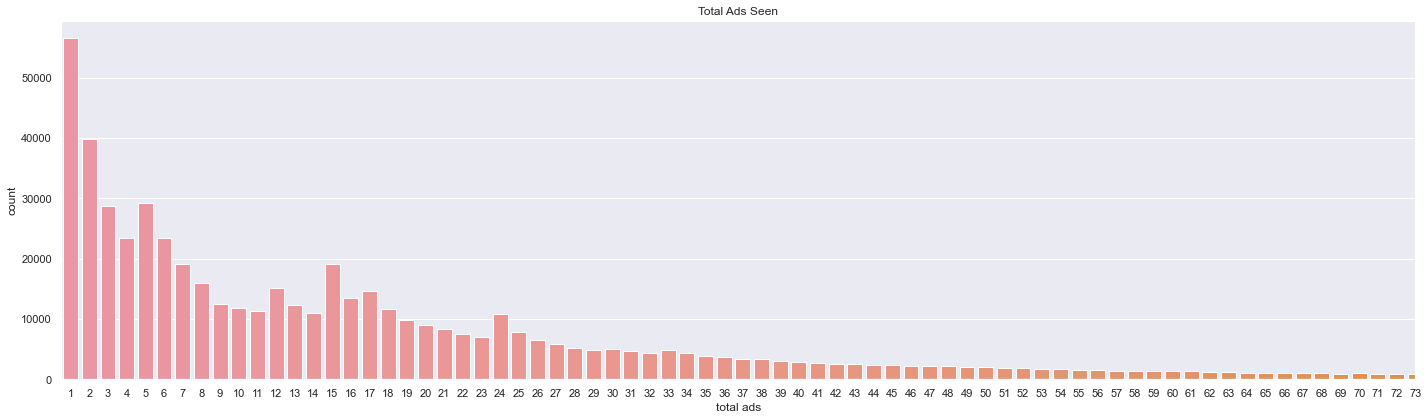

In [391]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(20,6)})
by_shown = sns.countplot(x = 'total ads', data = data)
by_shown.set(title='Total Ads Seen', xlim=(-.5,72) )
plt.show(by_shown)

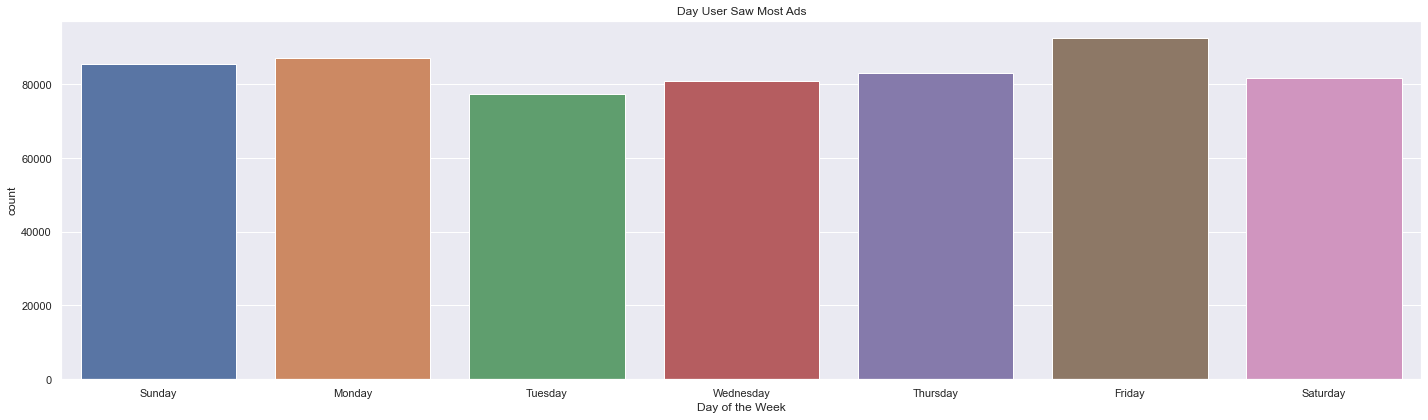

In [392]:
by_day = sns.countplot(x = 'most ads day', data = data)
xtick_labels = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
by_day.set(title = 'Day User Saw Most Ads')
by_day.set_xticklabels(xtick_labels)
by_day.set_xlabel('Day of the Week')
plt.show(by_day)

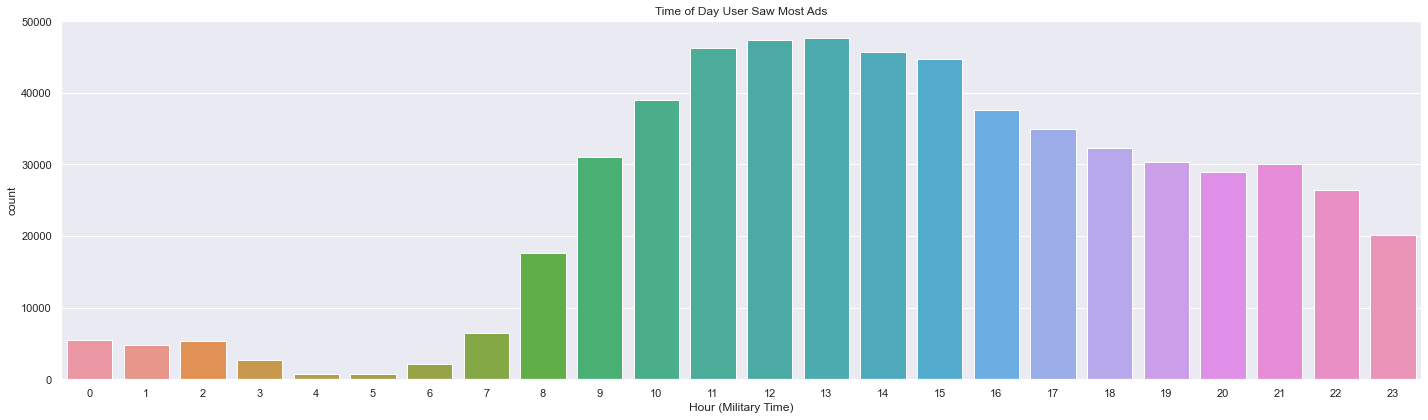

In [393]:
by_time = sns.countplot(x = 'most ads hour', data = data)
by_time.set(title = 'Time of Day User Saw Most Ads')
by_time.set_xlabel('Hour (Military Time)')
plt.show(by_time)

The number of customers who saw more than 71 adds was: 41296 or approximately 7.02 %


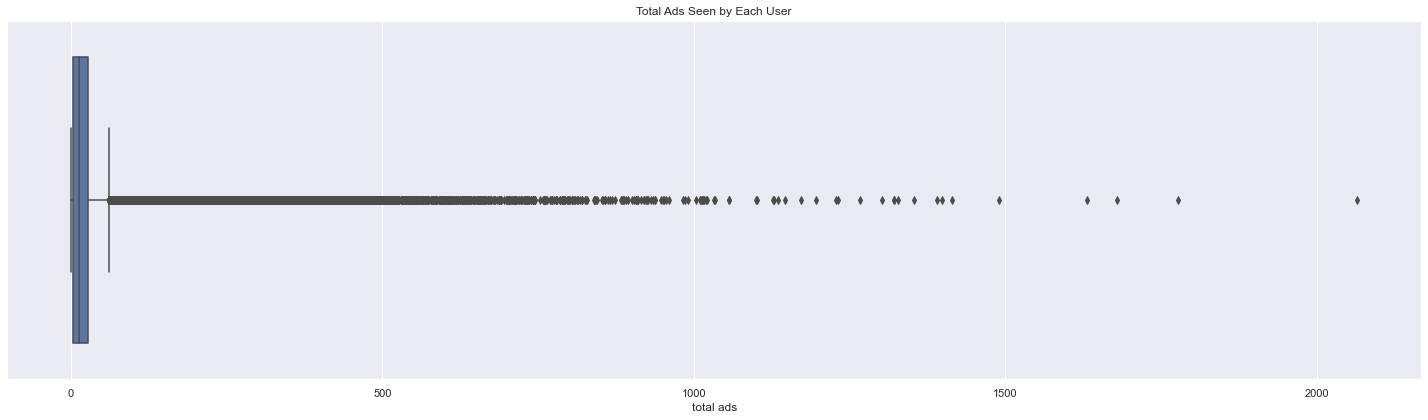

In [394]:
# take a closer look at outliers in number of ads shown
by_seen_total = sns.boxplot(data=data, x = 'total ads')
by_seen_total.set(title = 'Total Ads Seen by Each User')
print('The number of customers who saw more than 71 adds was: ' + str(data[data['total ads']>71]['total ads'].count()) + ' or approximately {:0.2f} %'.format(data[data['total ads']>71]['total ads'].count()*100/data['total ads'].count()))

We can from the figures above that most users were shown a relatively small number of ads (13 on average) but that some users were exposed to significantly more. We can also see that the ads were almost evenly distributed throughout the week, and that few ads were shown between the hours of midnight and 8am.

1    564577
0     23524
Name: test group, dtype: int64


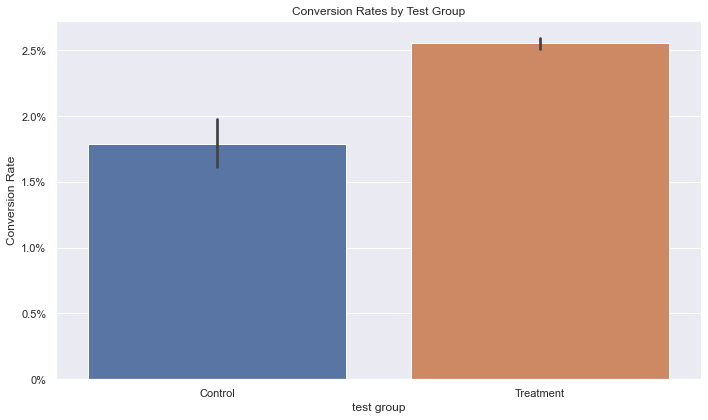

In [395]:
# graph conversion rates for both control and treatment groups
print(data['test group'].value_counts())
sns.set(rc={'figure.figsize':(10,6)})
total_conversions = sns.barplot(data=data, x = data['test group'], y = data['converted'])
total_conversions.set(title='Conversion Rates by Test Group')
total_conversions.set_ylabel('Conversion Rate')
plt.xticks([0,1],['Control','Treatment'])
plt.yticks([0.000,0.005,0.010,0.015,0.020,0.025],['0%','0.5%','1.0%','1.5%','2.0%','2.5%'])
plt.show(total_conversions)

In [396]:
# numerical values for conversion rates of both control and treatment groups
print(data.groupby('test group')['converted'].mean())

test group
0    0.017854
1    0.025547
Name: converted, dtype: float64


we can see that the conversion rate for those shown ads is 43% higher than those shown psa's 

In [397]:
# were there any duplicate users?
print(data['user id'].duplicated().sum())
# no duplicates were found

0


Frequentist A/B test
-we will use a two tailed test because we dont know how the ads will effect conversion rate
-H_0: Conversion_no_ads = Conversion_with_Ads
-H_a: Conversion_no_ads != Conversion_with_Ads
- set confidence level at 95% -> alpha = 0.05
- set power level at 0.8 by convention
-

In [398]:
# set power level and statistical significance 
alpha = 0.05
power = 0.8

In [419]:
# determine baseline conversion rate. we will say for the sake of this experiment that we took a random sample of 10,000 instances of customers 
# not shown adds to determine our baseline conversion rate
random.seed(42)
control_df = data[data['test group']==0]
converted_list = (control_df['converted']).to_list()
baseline_conversion = mean(random.choices(converted_list,k = 10000))
print('The baseline conversion rate is: ', round(baseline_conversion*100,2), '%')

# determine a standard deviation
means = []
for i in range(10000):
    means.append(mean(random.choices(converted_list,k = 10000)))
baseline_std = np.std(means)
print('The baseline standard deviation is: ', round(baseline_std*100,2), '%')

#calculate minimum observable effect size
min_lift = .25
min_effect_size = (baseline_conversion*(1+min_lift)- baseline_conversion)/baseline_std
MDE = baseline_conversion*(1+min_lift)
print('The minimum detectable effect size is: ',min_effect_size)

The baseline conversion rate is:  1.76 %
The baseline standard deviation is:  0.13 %
The minimum detectable effect size is:  3.3831393366350384


In [400]:
# sample size calculation
Z_alpha_half = stats.norm.ppf(1-alpha/2)
print('z/2: ',stats.norm.ppf(1-alpha/2))
Z_beta = stats.norm.ppf(power)
print('z_b: ', Z_beta)

n = round(((Z_alpha_half*math.sqrt(2*baseline_conversion*(1-baseline_conversion))+Z_beta*math.sqrt(baseline_conversion*(1-baseline_conversion)+MDE*(1-MDE)))**2)/(MDE-baseline_conversion)**2)
print('The minimum sample size for this test will be: ', n)

z/2:  1.959963984540054
z_b:  0.8416212335729143
The minimum sample size for this test will be:  14524


since our control group contains 23524 members and our test group is roughly 24x this size we have plenty of observations to conduct this test with the desired accuracy. 

frequentist analysis using only required sample size
we wish to determine specifically if the treatment group has a higher mean than the control so we will be using a 1 sided t-test

In [401]:
# generate simulated samples of minimum size
treatment_results = data[data['test group']==1]['converted']
control_results = data[data['test group']==0]['converted']
random.seed(42)
treatment_results_sim = list(random.sample(list(treatment_results), k = n))
control_results_sim = list(random.sample(list(control_results), k = n))

In [402]:
# calculating z statistic and p-value
n_converted = len(control_results_sim)
n_treatment = len(treatment_results_sim)
successes = [sum(control_results_sim), sum(treatment_results_sim)]
nobs = [n_converted, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs, alternative = 'smaller')
(lower_con, lower_treatment), (upper_con, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print('z statistic: ', -z_stat)
print('p-value: ', p_val)
print('95% confidence interval for control group: ' , format(lower_con,'.3f'), format(upper_con,'.3f'))
print('95% confidence interval for control group: ' , format(lower_treatment,'.3f'), format(upper_treatment,'.3f'))
print('Estimated Lift: ', round(((mean(treatment_results_sim)/mean(control_results_sim))-1)*100,2), '%')

z statistic:  3.66834177466072
p-value:  0.00012206435074195451
95% confidence interval for control group:  0.016 0.021
95% confidence interval for control group:  0.022 0.027
Estimated Lift:  33.83 %


with a p-value of 0.0001 we were able to determine that there was more than enough evidence to reject to null hypothesis and conclude that the treatment group has conversion rate higher than the control group

fequentist analysis using entire dataset

In [403]:
# calculating z statistic and p-value
n_converted = len(control_results)
n_treatment = len(treatment_results)
successes = [sum(control_results), sum(treatment_results)]
nobs = [n_converted, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs, alternative = 'smaller')
(lower_con, lower_treatment), (upper_con, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print('z statistic: ', -z_stat)
print('p-value: ', p_val)
print('95% confidence interval for control group: ' , format(lower_con,'.3f'), format(upper_con,'.3f'))
print('95% confidence interval for control group: ' , format(lower_treatment,'.3f'), format(upper_treatment,'.3f'))
print('Estimated Lift: ', round(((mean(treatment_results)/mean(control_results))-1)*100,2), '%')


z statistic:  7.3700781265454145
p-value:  8.526403580779863e-14
95% confidence interval for control group:  0.016 0.020
95% confidence interval for control group:  0.025 0.026
Estimated Lift:  43.09 %


and we can see that if we kept collecting data (considered the entire dataset) then the p-value of 8.5e-14 allows us to very safely reject the null hypothesis.

Bayesian A/B test 

In order to conduct a Baysean test we need to establish a prior distribution.

I will use a beta distribution because we have binary results between of 0 and 1 for conversion. So as not to effect our data significantly, I will use small values of alpha and beta relative to our test set to reflect low confidence in our initial assumptions. I will use an alpha of 1.76 and a beta of 98.24

Text(0.5, 0, 'Conversion Rate')

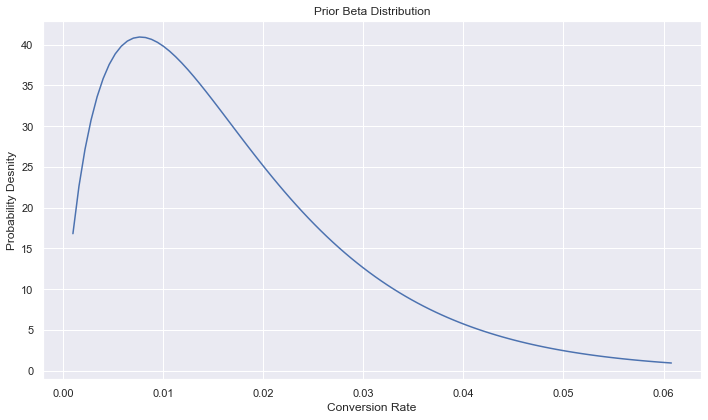

In [404]:
# create and graph a beta distribution to represent our prior assumptions based on the baseline found earlier
sns.set(rc={'figure.figsize':(10,6)})

prior_alpha = 1.76
prior_beta = 98.24
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 100)
ax.plot(x, stats.beta.pdf(x, prior_alpha, prior_beta))
ax.set(title = 'Prior Beta Distribution')
ax.set_ylabel('Probability Desnity')
ax.set_xlabel('Conversion Rate')

results of the test

The estimated lift is:  41.27 %
Probability that treatment results in higher conversion rate:  99.99900000000001 %
Probability that treatment results in greater than a 10% lift:  99.944 %
Probability that treatment results in greater than a 20% lift:  98.164 %
Probability that treatment results in greater than a 25% lift:  94.004 %
Probability that treatment results in greater than a 33% lift:  77.866 %
There is a 90% probability that the control mean conversion is between  1.66 % and  2.02 %
There is a 90% probability that the treatment mean conversion is between  2.38 % and  2.82 %
There is a 90% probability that the relative lift is between  24.2 % and  61.0 %


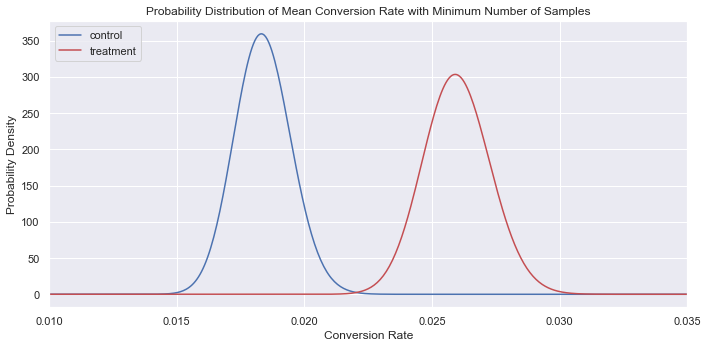

In [429]:
# using minimum sample size
random.seed(314)

# create sample sets of minimum size 
treatment_min = random.sample(list(data[data['test group']==1]['converted']),k = n)
control_min = random.sample(list(data[data['test group']==0]['converted']),k = n)

#calculate number converted and not converted for each group
control_converted = sum(control_min)
treatment_converted = sum(treatment_min)
control_not_convereted = len(control_min) - control_converted
treatment_not_convereted = len(treatment_min) - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000)
treatment_samples = posterior_treatment.rvs(100000)

# calculate probabilities 
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_10 = np.mean(treatment_samples>(control_samples*1.1))
print('Probability that treatment results in greater than a 10% lift: ', round(prob_lift_10*100,3), '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', round(prob_lift_20*100,3), '%')
prob_lift_25 = np.mean(treatment_samples>(control_samples*1.25))
print('Probability that treatment results in greater than a 25% lift: ', round(prob_lift_25*100,3), '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', round(prob_lift_33 *100,3), '%')


# calculate 95% confidence intervals
lift = ((treatment_samples/control_samples)-1)*100
control_lowerbound , control_upperbound = np.percentile(control_samples,5), np.percentile(control_samples,95)
print('There is a 90% probability that the control mean conversion is between ', round(control_lowerbound*100,2), '% and ', round(control_upperbound*100,2), '%')
treatment_lowerbound , treatment_upperbound = np.percentile(treatment_samples,5), np.percentile(treatment_samples,95)
print('There is a 90% probability that the treatment mean conversion is between ', round(treatment_lowerbound*100,2), '% and ', round(treatment_upperbound*100,2), '%')
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')



# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 1000)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'b-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'r-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate
# control_mean = np.mean(control_samples)
# plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '33% lift')

# format the graph
plt.legend(loc = 'upper left')
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Probability Density')
ax.set(title = 'Probability Distribution of Mean Conversion Rate with Minimum Number of Samples')
ax.set_xbound(0.01,0.035)


While using the minimum required sample size we can be 95% confident that we will achieve a 24.2% lift, this is just shy of the 25% we were hoping for.

The estimated lift is:  46.49 %
Probability that treatment results in higher conversion rate:  100.0 %
Probability that treatment results in greater than a 10% lift:  100.0 %
Probability that treatment results in greater than a 20% lift:  99.936 %
Probability that treatment results in greater than a 25% lift:  99.468 %
Probability that treatment results in greater than a 33% lift:  93.897 %
There is a 90% probability that the control mean conversion is between  1.65 % and  1.93 %
There is a 90% probability that the treatment mean conversion is between  2.45 % and  2.79 %
There is a 90% probability that the relative lift is between  32.2 % and  62.4 %


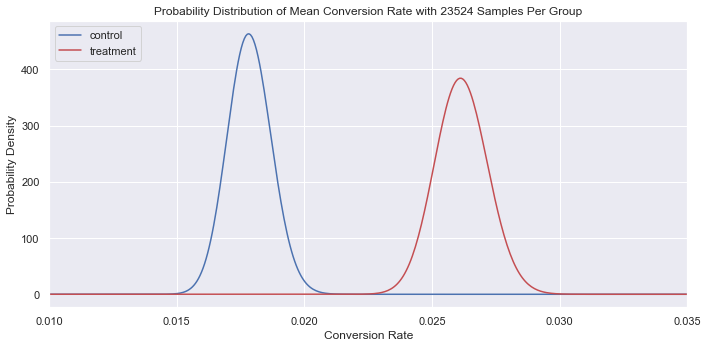

In [430]:
# using even control and treatment sets of equal size
random.seed(314)

# create a treatment sample sets of same size as control group
treatment_even = random.sample(list(data[data['test group']==1]['converted']),k = 23524)

#calculate number converted and not converted for each group
control_converted = data[data['test group']==0]['converted'].sum()
treatment_converted = sum(treatment_even)
control_not_convereted = data[data['test group']==0]['converted'].count() - control_converted
treatment_not_convereted = len(treatment_even) - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000)
treatment_samples = posterior_treatment.rvs(100000)

# calculate probabilities 
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_10 = np.mean(treatment_samples>(control_samples*1.1))
print('Probability that treatment results in greater than a 10% lift: ', round(prob_lift_10*100,3), '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', round(prob_lift_20*100,3), '%')
prob_lift_25 = np.mean(treatment_samples>(control_samples*1.25))
print('Probability that treatment results in greater than a 25% lift: ', round(prob_lift_25*100,3), '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', round(prob_lift_33 *100,3), '%')

# calculate 95% confidence intervals
lift = ((treatment_samples/control_samples)-1)*100
control_lowerbound , control_upperbound = np.percentile(control_samples,5), np.percentile(control_samples,95)
print('There is a 90% probability that the control mean conversion is between ', round(control_lowerbound*100,2), '% and ', round(control_upperbound*100,2), '%')
treatment_lowerbound , treatment_upperbound = np.percentile(treatment_samples,5), np.percentile(treatment_samples,95)
print('There is a 90% probability that the treatment mean conversion is between ', round(treatment_lowerbound*100,2), '% and ', round(treatment_upperbound*100,2), '%')
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')

# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 1000)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'b-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'r-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate
# control_mean = np.mean(control_samples)
# plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '33% lift')

# format the graph
plt.legend(loc = 'upper left')
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Probability Density')
ax.set(title = 'Probability Distribution of Mean Conversion Rate with 23524 Samples Per Group')
ax.set_xbound(0.01,0.035)

Using a larger dataset we are now 95% confident we will achive a lift of 32.2% and we are ~99.5% confident that we will achive the desired lift of 25%

The estimated lift is:  43.11 %
Probability that treatment results in higher conversion rate:  100.0 %
Probability that treatment results in greater than a 10% lift:  100.0 %
Probability that treatment results in greater than a 20% lift:  99.989 %
Probability that treatment results in greater than a 25% lift:  99.763 %
Probability that treatment results in greater than a 33% lift:  93.661 %
There is a 90% probability that the control mean conversion is between  1.65 % and  1.93 %
There is a 90% probability that the treatment mean conversion is between  2.52 % and  2.59 %
There is a 90% probability that the relative lift is between  32.2 % and  55.4 %


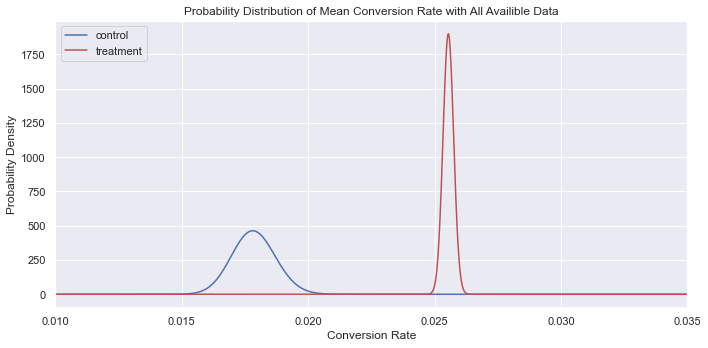

In [432]:
# using entire data set
random.seed(314)
#calculate number converted and not converted for each group
control_converted = data[data['test group']==0]['converted'].sum()
treatment_converted = data[data['test group']==1]['converted'].sum()
control_not_convereted = data[data['test group']==0]['converted'].count() - control_converted
treatment_not_convereted = data[data['test group']==1]['converted'].count() - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000)
treatment_samples = posterior_treatment.rvs(100000)

# calculate probabilities 
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_10 = np.mean(treatment_samples>(control_samples*1.1))
print('Probability that treatment results in greater than a 10% lift: ', round(prob_lift_10*100,3), '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', round(prob_lift_20*100,3), '%')
prob_lift_25 = np.mean(treatment_samples>(control_samples*1.25))
print('Probability that treatment results in greater than a 25% lift: ', round(prob_lift_25*100,3), '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', round(prob_lift_33 *100,3), '%')

# calculate 95% confidence intervals
lift = ((treatment_samples/control_samples)-1)*100
control_lowerbound , control_upperbound = np.percentile(control_samples,5), np.percentile(control_samples,95)
print('There is a 90% probability that the control mean conversion is between ', round(control_lowerbound*100,2), '% and ', round(control_upperbound*100,2), '%')
treatment_lowerbound , treatment_upperbound = np.percentile(treatment_samples,5), np.percentile(treatment_samples,95)
print('There is a 90% probability that the treatment mean conversion is between ', round(treatment_lowerbound*100,2), '% and ', round(treatment_upperbound*100,2), '%')
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')

# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 10000)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'b-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'r-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate and 75% of average treatment conversion rate
# control_mean = np.mean(control_samples)
# plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '133% of control mean')
# treatment_mean = np.mean(treatment_samples)
# plt.axvline(x = treatment_mean*.75, color = 'b',linestyle = 'dashed', label = '75% of treatment mean')

#format the graph
plt.legend(loc = 'upper left')
ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Probability Density')
ax.set(title = 'Probability Distribution of Mean Conversion Rate with All Availible Data')
ax.set_xbound(0.01,0.035)

Using all availible data we are still 95% confident that we will achieve a 32.3% lift, but we are now ~99.8% sure that we will achieve our desired lift of 25%

When and how many of these ads should we run?

In [408]:
# find 50th,90th,95th,and 99th percentiles of number of ads or psas seen of users
p_50_raw = np.percentile(data['total ads'],50)
p_90_raw = np.percentile(data['total ads'],90)
p_95_raw = np.percentile(data['total ads'],95)
p_99_raw = np.percentile(data['total ads'],99)
print(p_50_raw,p_90_raw,p_95_raw,p_99_raw)

13.0 57.0 88.0 202.0


50% of Users saw 13 or fewer ads
90% of Users saw 57 or fewer ads
95% of Users saw 88 or fewer ads
99% of Users saw 202 or fewer ads

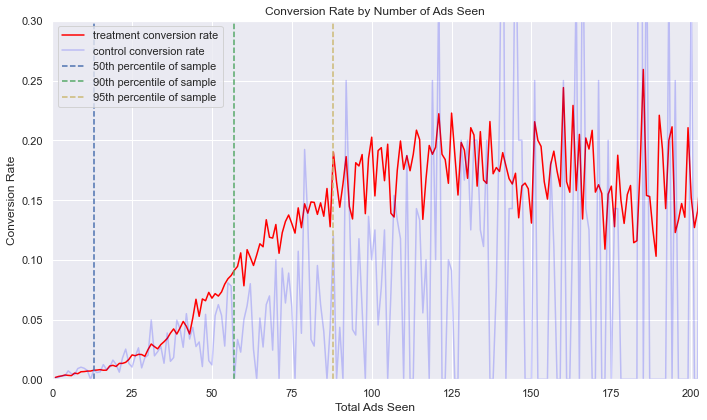

In [409]:
#graph average conversion rate as a function of number of ads seen
num_ads_effect = data[data['test group']==1].groupby('total ads')['converted'].mean()
num_psa_effect = data[data['test group']==0].groupby('total ads')['converted'].mean()
num_ads_effect.plot(c='red', label = 'treatment conversion rate',)
num_psa_effect.plot(c='blue', alpha = 0.2, label = 'control conversion rate')

# add guidelines for sample percentiles
plt.axvline(x = p_50_raw, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90_raw, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95_raw, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

# format graph
plt.legend()
plt.xlim(0,202)
plt.ylim(0,.3)
plt.ylabel('Conversion Rate')
plt.xlabel('Total Ads Seen')
plt.title('Conversion Rate by Number of Ads Seen')
plt.show()


In [411]:
# create bins for number of ads seen to reduce noise
data['bin']= (data['total ads']/10).apply(np.floor)
p_50 = np.percentile(data['bin'],50)
p_90 = np.percentile(data['bin'],90)
p_95 = np.percentile(data['bin'],95)
p_99 = np.percentile(data['bin'],99)
print(p_50,p_90,p_95, p_99)

1.0 5.0 8.0 20.0


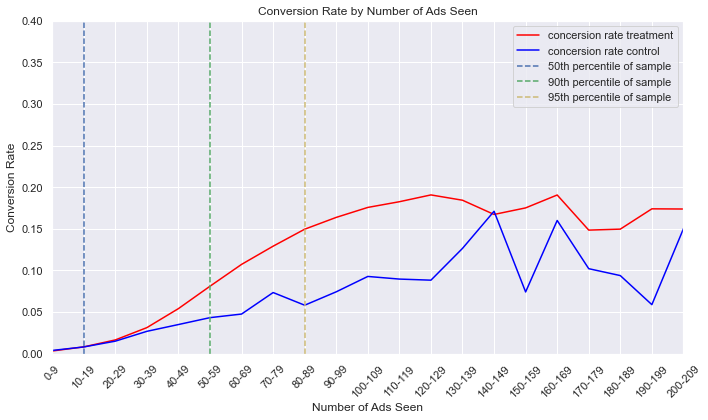

In [412]:
#graph average conversion rate as a function of tens of ads seen
num_ads_effect = data[data['test group']==1].groupby('bin')['converted'].mean()
num_psa_effect = data[data['test group']==0].groupby('bin')['converted'].mean()
num_ads_effect.reset_index()
fig, ax = plt.subplots(1,1)
num_ads_effect.plot(ax = ax, color='red', label = 'concersion rate treatment')
num_psa_effect.plot(ax = ax, color='blue',label = 'concersion rate control')

# add guidelines for sample percentiles
plt.axvline( x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

#format graph
plt.rcParams['figure.figsize'] = [10,5]
plt.xlim(0,20)
plt.ylim(0,.4)
plt.legend()
plt.ylabel('Conversion Rate')
plt.xlabel('Number of Ads Seen')
plt.title('Conversion Rate by Number of Ads Seen')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129','130-139','140-149','150-159','160-169','170-179','180-189','190-199','200-209'], rotation = 45)
plt.show()

we can see that showing more adds or seeing more PSAs both result in a higher conversion rate untill you reach about 100 adds or soo before the conversion rate levels off.

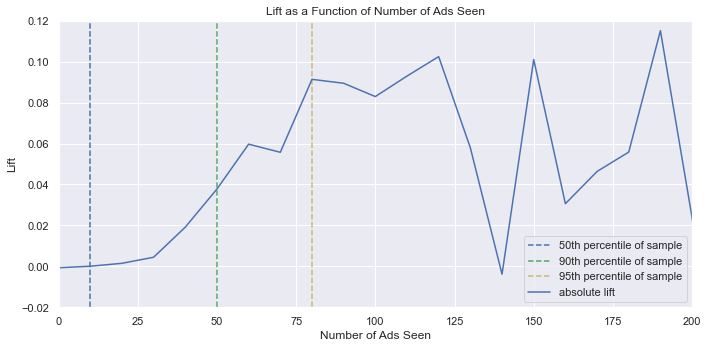

In [413]:
# calculate absolute lift as a function of tens of ads
ads_effect = data[data['test group']==1].groupby('bin', as_index = False)['converted'].mean().rename(columns = {'converted': 'mean conversion adds'})
psa_effect = data[data['test group']==0].groupby('bin', as_index=False)['converted'].mean().rename(columns = {'converted': 'mean conversion psas'})
combined = ads_effect.merge(psa_effect, on='bin')
combined['absolute lift']=(combined['mean conversion adds']-combined['mean conversion psas'])

# add guidelines for sample percentiles
plt.axvline(x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

#format graph of absolute lift
plt.plot(combined['bin'],combined['absolute lift'], label = 'absolute lift')
plt.legend()
plt.title('Lift as a Function of Number of Ads Seen')
plt.xlabel('Number of Ads Seen')
plt.ylabel('Lift')
plt.xlim(0,20)
plt.ylim(-.02,.12)
plt.xticks([0,2.5,5,7.5,10,12.5,15,17.5,20],[0,25,50,75,100,125,150,175,200])
plt.show()



in examining the lift, we can see that more adds translates to a greater lift relative to PSAs untill you reach 120 adds or so beyond which a lack of data yields noisy results, but does not appear to increase the conversion rate. 

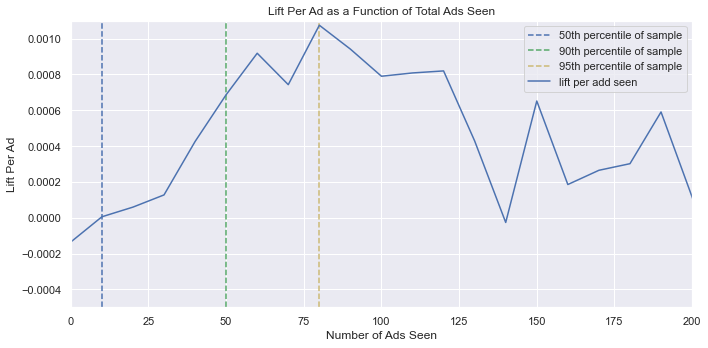

In [414]:
# calculate absolute lift per ad 
combined['lift per add']=(combined['mean conversion adds']-combined['mean conversion psas'])/((combined['bin']*10)+5)

# add guidelines for sample percentiles
plt.axvline(x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

# format graph
plt.plot(combined['bin'],combined['lift per add'], label = 'lift per add seen')
plt.legend()
plt.title('Lift Per Ad as a Function of Total Ads Seen')
plt.xlabel('Number of Ads Seen')
plt.ylabel('Lift Per Ad')
plt.xlim(0,20)
plt.ylim(-.0005,.0011)
plt.xticks([0,2.5,5,7.5,10,12.5,15,17.5,20],[0,25,50,75,100,125,150,175,200])
plt.show()

once we look at the lift per add shown, however, we can see a maximum around 80 adds beyond which we see a gradual decrease to 0

Based on the above figures, we can can conclude that we would idealy show users more than 50 ads to get the greatest impact per ad and that do not show them more than 100 or 120 adds because beyond this point seeing more ads does not contribute to more conversions, just more expenses. 

When should you run these adds?

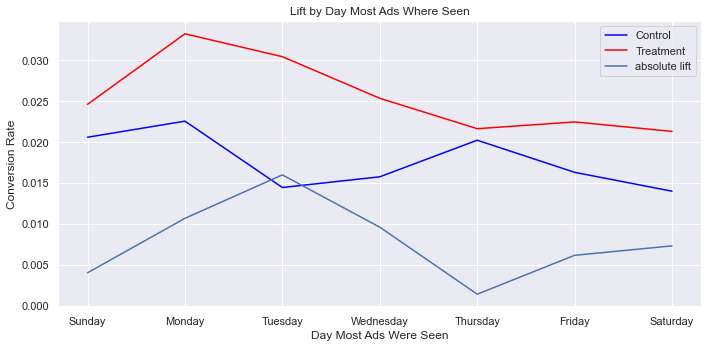

In [415]:
# find mean conversion rates by day ads seen
add_by_day = data[data['test group']==1].groupby('most ads day')['converted'].mean()
psa_by_day = data[data['test group']==0].groupby('most ads day')['converted'].mean()

# plot the conversion rates as a function of day
psa_by_day.plot(color = 'blue', label = 'Control')
add_by_day.plot(color = 'red', label = 'Treatment')

# find and plot absolute lift by day ads seen
lift_by_day = add_by_day.to_frame().merge(psa_by_day, on = 'most ads day')
lift_by_day['absolute lift'] = lift_by_day['converted_x']-lift_by_day['converted_y']
lift_by_day['absolute lift'].plot()

#format graph
plt.legend()
plt.title('Lift by Day Most Ads Where Seen')
plt.xlabel('Day Most Ads Were Seen')
plt.ylabel('Conversion Rate')
plt.xticks([1,2,3,4,5,6,7],['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.show()


We can see that when the most adds are seen on Monday or Tuesday we get the highest conversion rate and that the adds result in the greatest lift on Monday through Wednesday. Ads shown on Sunday and Thursday appear to have the smallest effect on lift. 

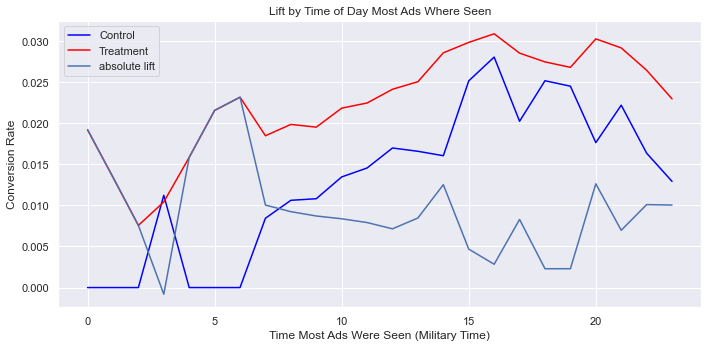

In [416]:
# find mean conversion rates by time of day ads seen
add_by_hour = data[data['test group']==1].groupby('most ads hour')['converted'].mean()
psa_by_hour = data[data['test group']==0].groupby('most ads hour')['converted'].mean()

# plot the conversion rates as a function of time of day
psa_by_hour.plot(color = 'blue', label = 'Control')
add_by_hour.plot(color = 'red', label = 'Treatment')

# find and plot absolute lift by day ads seen
lift_by_hour = add_by_hour.to_frame().merge(psa_by_hour, on = 'most ads hour')
lift_by_hour['absolute lift'] = lift_by_hour['converted_x']-lift_by_hour['converted_y']
lift_by_hour['absolute lift'].plot()

# format graph
plt.title('Lift by Time of Day Most Ads Where Seen')
plt.xlabel('Time Most Ads Were Seen (Military Time)')
plt.ylabel('Conversion Rate')
plt.legend()
plt.show()

We can see that the greatest absolute lift occured between midnight and 6am. However, only about 7% of our dataset contains information about this time period and that the conversion rate for people only shown PSA's is essentially 0. We are not be able to conclude that these results are significant due to insufficient data. Beyond 6am, the lift achieved was relatively consistent leading to the conclusion that the time of day that the ads are shown is not a significant contributing factor to our desired outcome. 

In [417]:
data[data['test group']==0].groupby('most ads hour')['converted'].count()

most ads hour
0      227
1      187
2      181
3       89
4       28
5       23
6       83
7      237
8      659
9     1202
10    1485
11    2061
12    2060
13    2170
14    1869
15    1828
16    1604
17    1383
18    1271
19    1183
20    1077
21    1081
22     917
23     619
Name: converted, dtype: int64